#EDA

In [223]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
os.getcwd()
print(os.getcwd())
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')


c:\Users\oscar\Desktop\VS_CODE\airbnb_analysis\notebooks


In [179]:
#load data
df_age_gender = pd.read_csv('C:/Users/oscar/Desktop/VS_CODE/raw_data/age_gender_bkts.csv')
df_countries = pd.read_csv('C:/Users/oscar/Desktop/VS_CODE/raw_data/countries.csv')
df_sessions = pd.read_csv('C:/Users/oscar/Desktop/VS_CODE/raw_data/sessions.csv')
df_train = pd.read_csv('C:/Users/oscar/Desktop/VS_CODE/raw_data/train_users_2.csv')
df_test = pd.read_csv('C:/Users/oscar/Desktop/VS_CODE/raw_data/test_users.csv')

In [180]:
df_all = pd.concat((df_train,df_test),axis= 0 ,ignore_index= True)

In [181]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [182]:
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

date_first_booking has 186639 null values

age has 116866 null values

first_affiliate_tracked has 6085 null values

country_destination has 62096 null values



In [183]:
#刪除date_first_booking，country_destination 欄位因為他們在test資料中都沒有
df_all = df_all.drop(['date_first_booking','country_destination'],axis= 1)


In [184]:
# age 和 first_affiliate_tracked 需處理缺失值
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

age has 116866 null values

first_affiliate_tracked has 6085 null values



In [185]:
df_all.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [186]:
df_train.gender.value_counts()

gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64

In [187]:
columns = df_all.columns.tolist()
columns = [col for col in columns if col not in ['id', 'date_account_created', 'timestamp_first_active']]

for i in columns:
    print(df_all[i].value_counts())


gender
-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: count, dtype: int64
age
30.0      7712
28.0      7687
29.0      7647
31.0      7540
27.0      7462
          ... 
1953.0       1
132.0        1
150.0        1
112.0        1
1941.0       1
Name: count, Length: 145, dtype: int64
signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64
signup_flow
0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: count, dtype: int64
language
en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da

In [188]:
#轉換成類別變數
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')


## 移到視覺化完再做

### data need processing
1. miss value
    - age
    - first_affiliate_tracked

2. age 有 outliner, K-means 偵測

3. language 只有test資料有一筆 unknown 


In [189]:
# #age 缺失值處理
# age_mode = df_all.age.mode()[0]
# df_all['age'].fillna(age_mode,inplace=True)

In [190]:
# first_affiliate_tracked_mode = df_all.first_affiliate_tracked.mode()[0]
# df_all['first_affiliate_tracked'].fillna(first_affiliate_tracked_mode,inplace=True)

In [191]:
# # age 異常檢測

# #標準化
# scalar = StandardScaler()
# df_all['age_scaled'] = scalar.fit_transform(df_all[['age']])


In [192]:
# #elbow method 找分群數
# sse = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df_all[['age_scaled']])
#     sse.append(kmeans.inertia_)

# plt.plot(range(1, 11), sse, marker='o')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('SSE')
# plt.title('Elbow Method')
# plt.show()


In [193]:
# # 分成 2 群
# kmeans = KMeans(n_clusters=2, random_state=42)
# df_all['age_cluster'] = kmeans.fit_predict(df_all[['age_scaled']])


In [194]:
# #異常年齡處理為眾數
# centroids = kmeans.cluster_centers_
# df_all['distance_to_centroid'] = np.linalg.norm(df_all[['age_scaled']].values - centroids[df_all['age_cluster']], axis=1)
# threshold = np.percentile(df_all['distance_to_centroid'], 99)
# df_all.loc[df_all['distance_to_centroid'] > threshold, 'age'] = 30

# Visualize

In [195]:
sns.set_style('whitegrid')
sns.set_context("notebook")

### gender
1. OTHER 比例很低，可能需要另外處理
2. unknown 比例佔將近50%
3. 男女各占一半左右


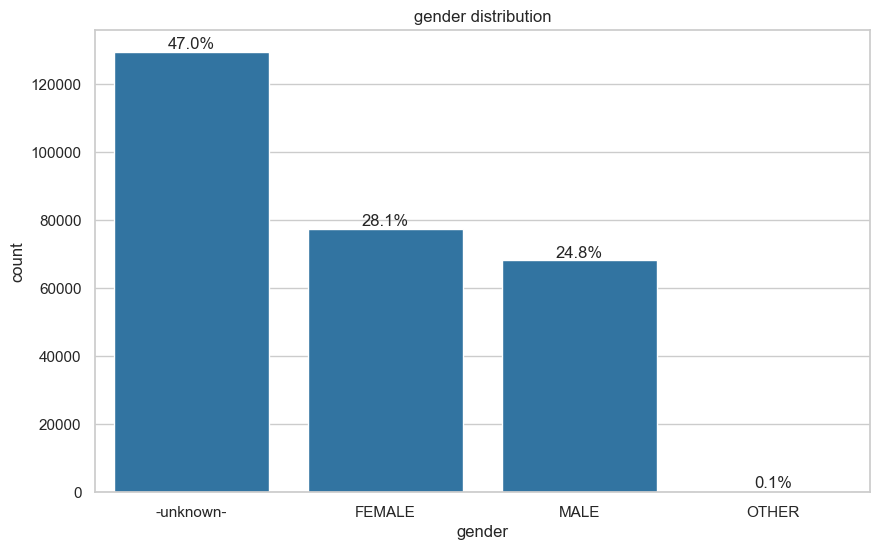

In [196]:
gender_counts = df_all['gender'].value_counts()
total_count = len(df_all)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='gender', order=gender_counts.index)
plt.title('gender distribution')
# 添加標籤
for index, value in enumerate(gender_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  


## Age
1. 資料大多集中在30歲左右
2. 有許多不合理的值(>100)(>2000)，需要另外處理

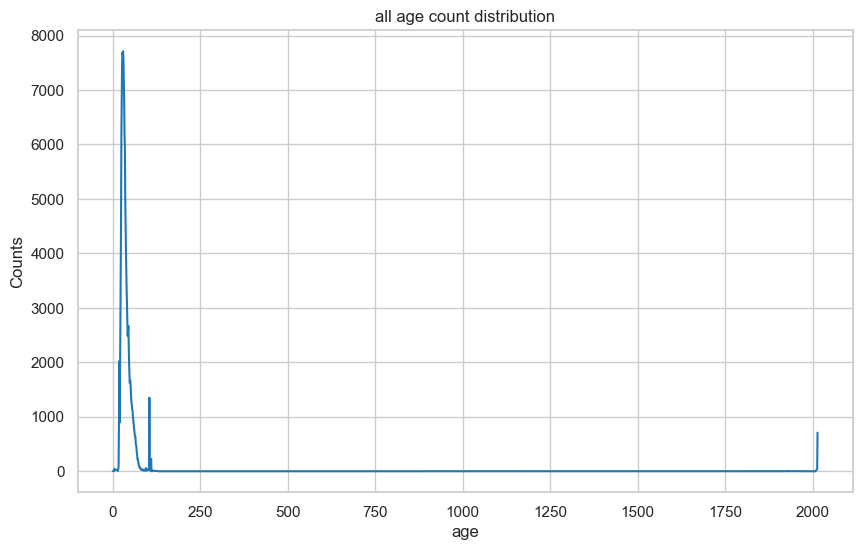

In [197]:
age_counts = df_all.age.value_counts().sort_index()

# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts.index, y=age_counts.values)
plt.ylabel('Counts')
plt.title('all age count distribution')

plt.show()

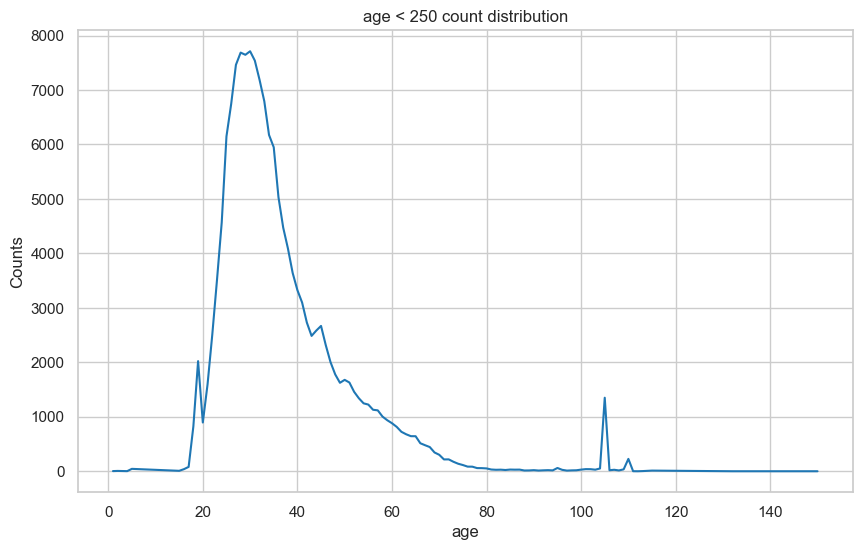

In [198]:
age_counts = df_all.age.value_counts().sort_index()
age_counts_250 = age_counts[age_counts.index<250]
# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts_250.index, y=age_counts_250.values)
plt.ylabel('Counts')
plt.title('age < 250 count distribution')

plt.show()

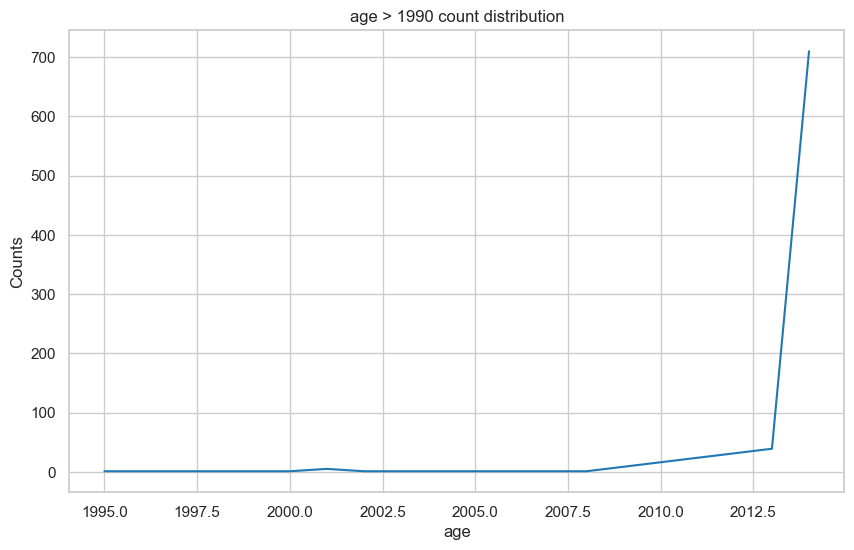

In [199]:
age_counts = df_all.age.value_counts().sort_index()
age_counts_1990 = age_counts[age_counts.index>1990]
# 畫折線圖
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_counts_1990.index, y=age_counts_1990.values)
plt.ylabel('Counts')
plt.title('age > 1990 count distribution')

plt.show()

## signup method
1. basic 佔7成
2. weibo 數量極少

signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64


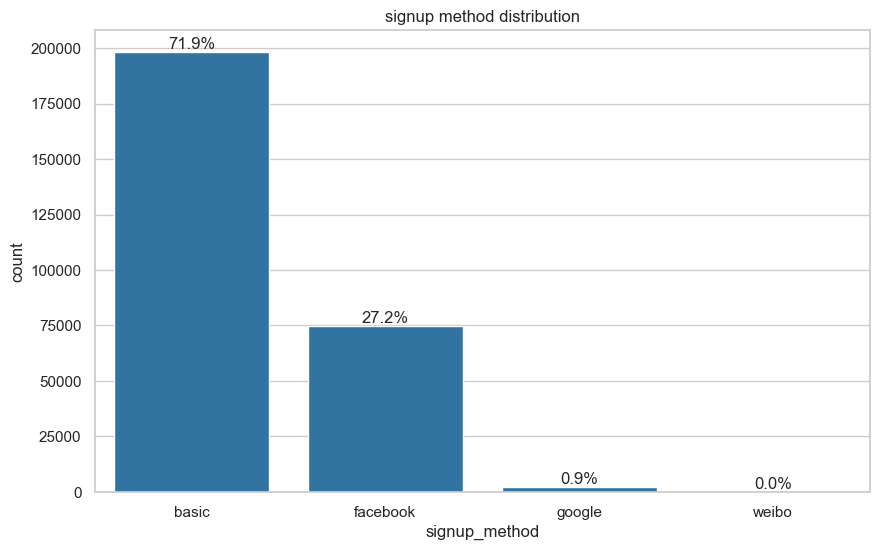

In [200]:
signup_method_counts = df_all['signup_method'].value_counts()
total_count = len(df_all)


print(signup_method_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_method', order=signup_method_counts.index)
plt.title('signup method distribution')
# 添加標籤
for index, value in enumerate(signup_method_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  


## signup flow
1. 可能是註冊流程編號
2. 大多類型為 1 
3. 有許多類別基數很低，可能需另外處理

signup_flow
0     206092
1       1047
2       6881
3       8822
4          1
5         36
6        301
8        315
10         2
12     11244
14         4
15        10
16        11
20        14
21       197
23      6408
24      4328
25     29834
Name: count, dtype: int64


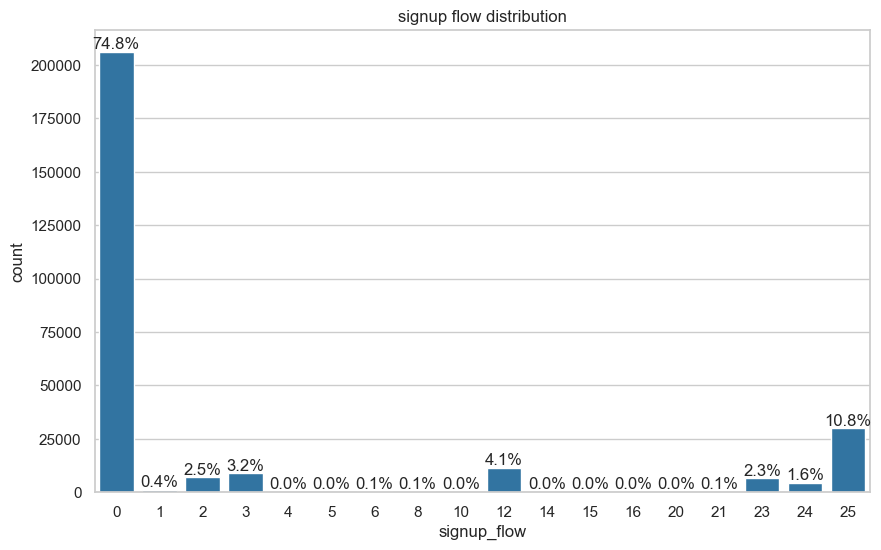

In [201]:
signup_flow_counts = df_all['signup_flow'].value_counts().sort_index()
total_count = len(df_all)


print(signup_flow_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_flow', order=signup_flow_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(signup_flow_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## language 
1. 英文的比例會很高，可能是因為資料來源地是美國
2. 可能需要考慮排除英文或其他處理方法

language
-unknown-         1
ca                6
cs               49
da               75
de              977
el               30
en           265538
es             1174
fi               20
fr             1508
hr                2
hu               25
id               23
is                5
it              633
ja              345
ko             1116
nl              134
no               51
pl               75
pt              322
ru              508
sv              176
th               28
tr               92
zh             2634
Name: count, dtype: int64


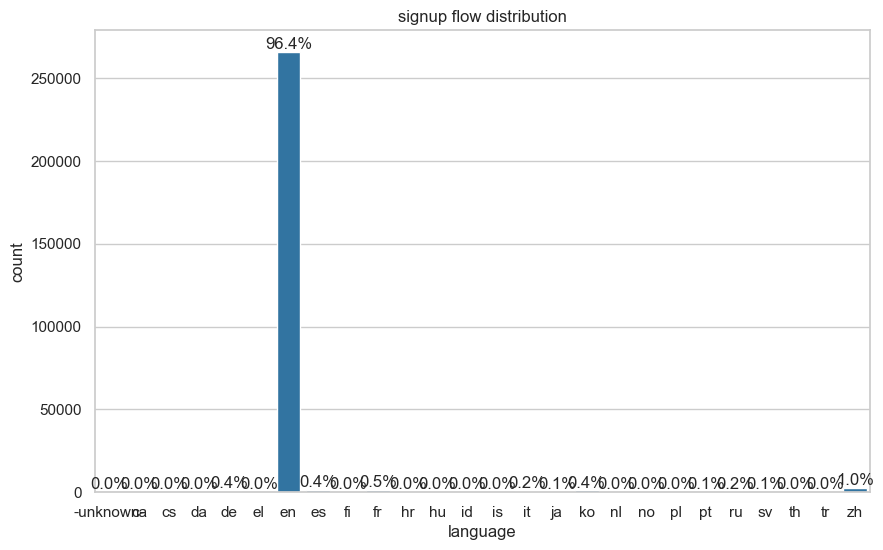

In [202]:
language_counts = df_all['language'].value_counts().sort_index()
total_count = len(df_all)


print(language_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='language', order=language_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(language_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

language
-unknown-       1
ca              6
cs             49
da             75
de            977
el             30
en              0
es           1174
fi             20
fr           1508
hr              2
hu             25
id             23
is              5
it            633
ja            345
ko           1116
nl            134
no             51
pl             75
pt            322
ru            508
sv            176
th             28
tr             92
zh           2634
Name: count, dtype: int64


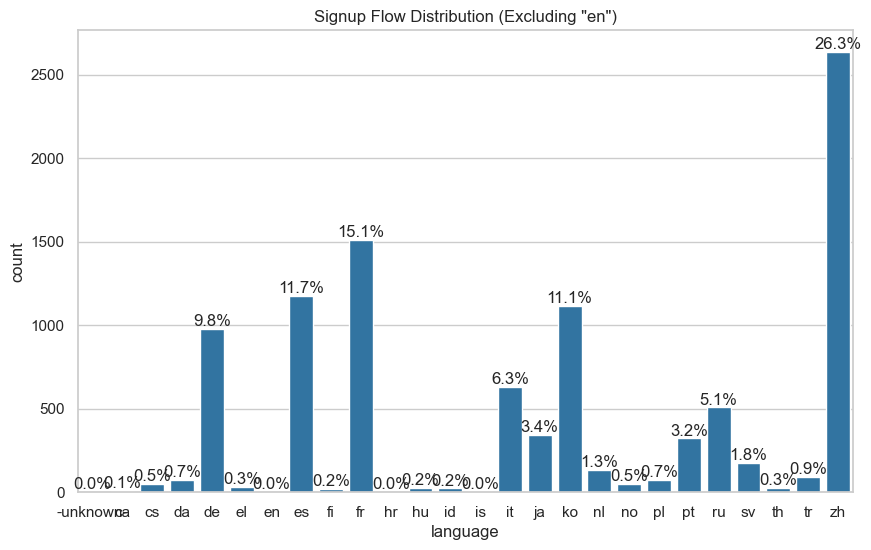

In [203]:
# 刪掉英文重做視覺化

# 篩選掉 'en' 的資料
df_filtered = df_all[df_all['language'] != 'en']

# 計算篩選後語言的分佈
language_counts = df_filtered['language'].value_counts().sort_index()
total_count = len(df_filtered)


print(language_counts)


plt.figure(figsize=(10,6))
sns.countplot(data=df_filtered, x='language', order=language_counts.index)
plt.title('Signup Flow Distribution (Excluding "en")')

# 添加標籤
for index, value in enumerate(language_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  


## affiliate_channel
1. 可能代表進入網站的方法
2. 比例較低的資料可能可以處理

affiliate_channel
api                8167
content            4118
direct           181571
other              9547
remarketing        1268
sem-brand         36439
sem-non-brand     20075
seo               14362
Name: count, dtype: int64


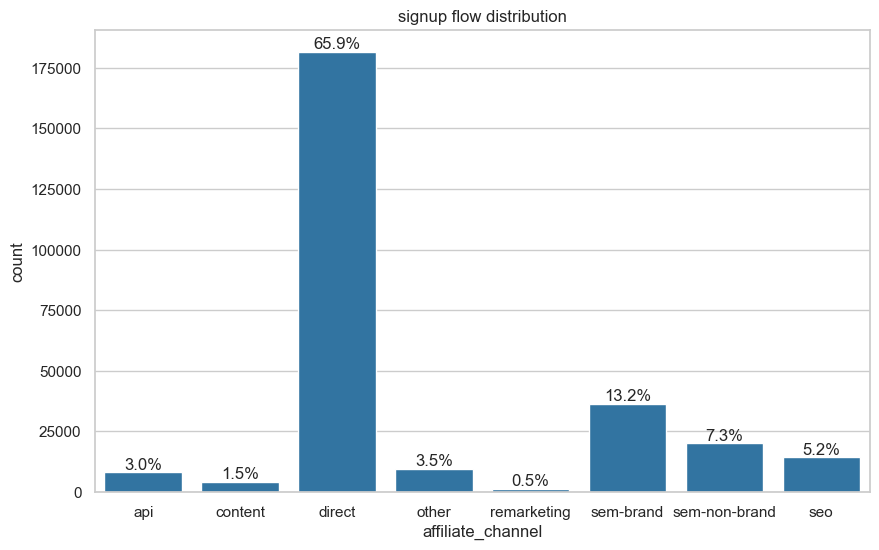

In [204]:
affiliate_channel_counts = df_all['affiliate_channel'].value_counts().sort_index()
total_count = len(df_all)


print(affiliate_channel_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='affiliate_channel', order=affiliate_channel_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(affiliate_channel_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## affiliate_provider_counts
1. 類別數量不平衡，只有三種較高

affiliate_provider
baidu                      32
bing                     3719
craigslist               3475
daum                        3
direct                 181270
email-marketing           270
facebook                 3996
facebook-open-graph       566
google                  65956
gsp                       455
meetup                    358
naver                      66
other                   13036
padmapper                 836
vast                      830
wayn                        8
yahoo                     653
yandex                     18
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'baidu'),
  Text(1, 0, 'bing'),
  Text(2, 0, 'craigslist'),
  Text(3, 0, 'daum'),
  Text(4, 0, 'direct'),
  Text(5, 0, 'email-marketing'),
  Text(6, 0, 'facebook'),
  Text(7, 0, 'facebook-open-graph'),
  Text(8, 0, 'google'),
  Text(9, 0, 'gsp'),
  Text(10, 0, 'meetup'),
  Text(11, 0, 'naver'),
  Text(12, 0, 'other'),
  Text(13, 0, 'padmapper'),
  Text(14, 0, 'vast'),
  Text(15, 0, 'wayn'),
  Text(16, 0, 'yahoo'),
  Text(17, 0, 'yandex')])

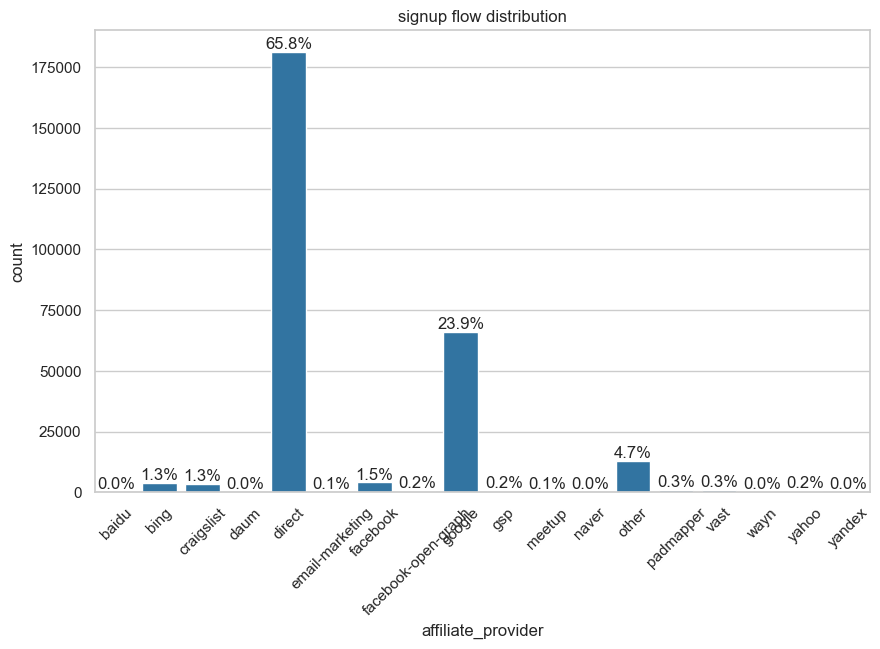

In [205]:
affiliate_provider_counts = df_all['affiliate_provider'].value_counts().sort_index()
total_count = len(df_all)


print(affiliate_provider_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='affiliate_provider', order=affiliate_provider_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(affiliate_provider_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

# 旋轉X軸的字標籤
plt.xticks(rotation=45)

## first_affiliate_tracked
1. 只有3類特別多，剩下的類別可能可以合併

first_affiliate_tracked
linked            62064
local ops            69
marketing           281
omg               54859
product            2353
tracked-other      6655
untracked        143181
Name: count, dtype: int64


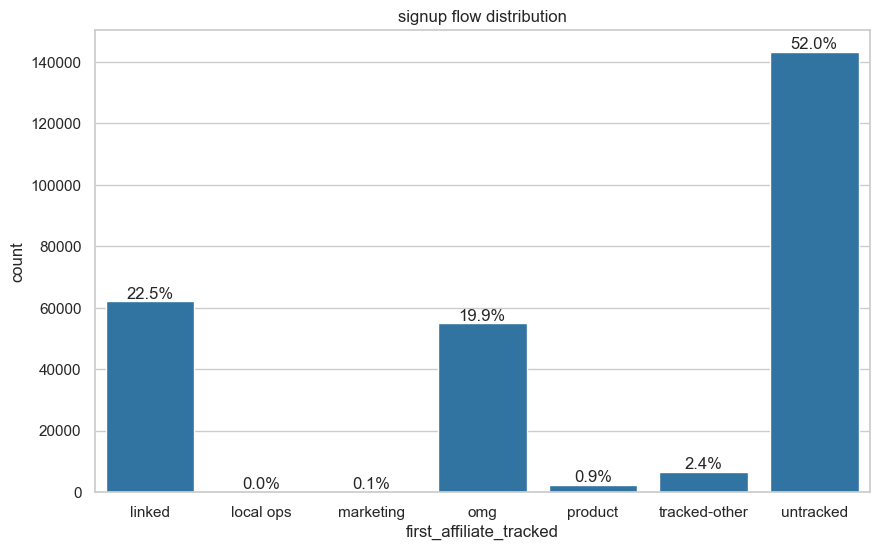

In [206]:

first_affiliate_tracked_counts = df_all['first_affiliate_tracked'].value_counts().sort_index()
total_count = len(df_all)


print(first_affiliate_tracked_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_affiliate_tracked', order=first_affiliate_tracked_counts.index)
plt.title('signup flow distribution')
# 添加標籤
for index, value in enumerate(first_affiliate_tracked_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## signup_app
1. web 比例最高

signup_app
Android     10519
Moweb       10517
Web        219918
iOS         34593
Name: count, dtype: int64


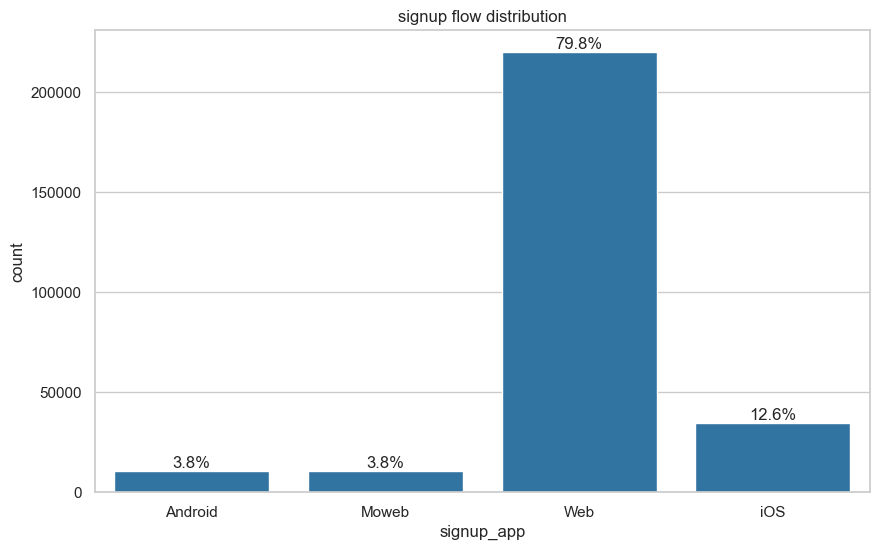

In [207]:
signup_app_counts = df_all['signup_app'].value_counts().sort_index()
total_count = len(df_all)


print(signup_app_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='signup_app', order=signup_app_counts.index)
plt.title('signup flow distribution')

# 添加標籤
for index, value in enumerate(signup_app_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## first_device_type

first_device_type
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
Mac Desktop           106328
Other/Unknown          11167
SmartPhone (Other)       191
Windows Desktop        86948
iPad                   18036
iPhone                 39814
Name: count, dtype: int64


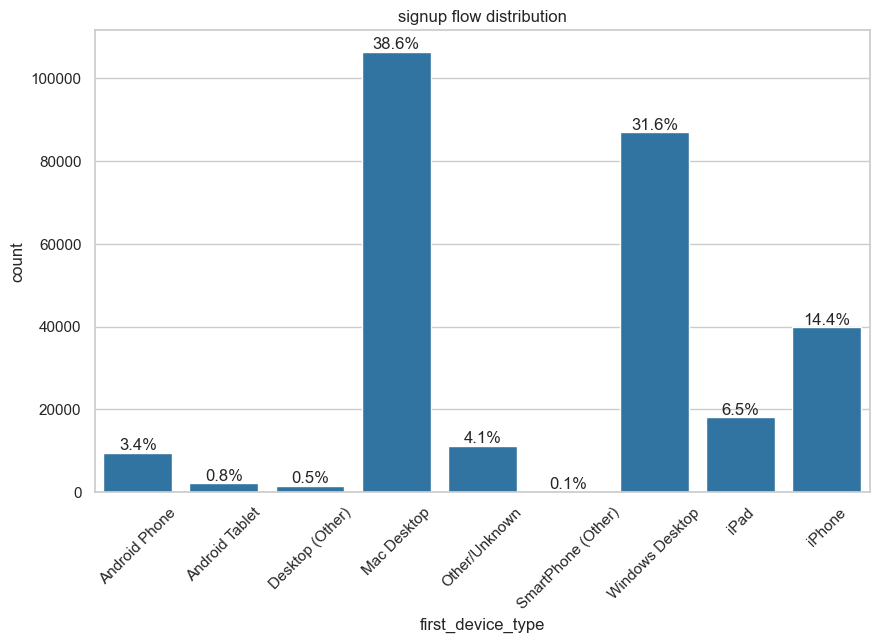

In [208]:

first_device_type_counts = df_all['first_device_type'].value_counts().sort_index()
total_count = len(df_all)


print(first_device_type_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_device_type', order=first_device_type_counts.index)
plt.title('signup flow distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(first_device_type_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## first_browser
1. 種類很多，但只有其中幾類占比夠高

first_browser
-unknown-               44394
AOL Explorer              254
Android Browser          1577
Apple Mail                 45
Arora                       1
Avant Browser               4
BlackBerry Browser         89
Camino                      9
Chrome                  78671
Chrome Mobile            3186
Chromium                   83
CometBird                  12
Comodo Dragon               2
Conkeror                    1
CoolNovo                    6
Crazy Browser               2
Epic                        1
Firefox                 38665
Flock                       2
Google Earth                1
Googlebot                   1
IBrowse                     1
IE                      24744
IE Mobile                 118
IceDragon                   1
IceWeasel                  14
Iron                       24
Kindle Browser              1
Maxthon                    60
Mobile Firefox             64
Mobile Safari           29636
Mozilla                     3
NetNewsWire               

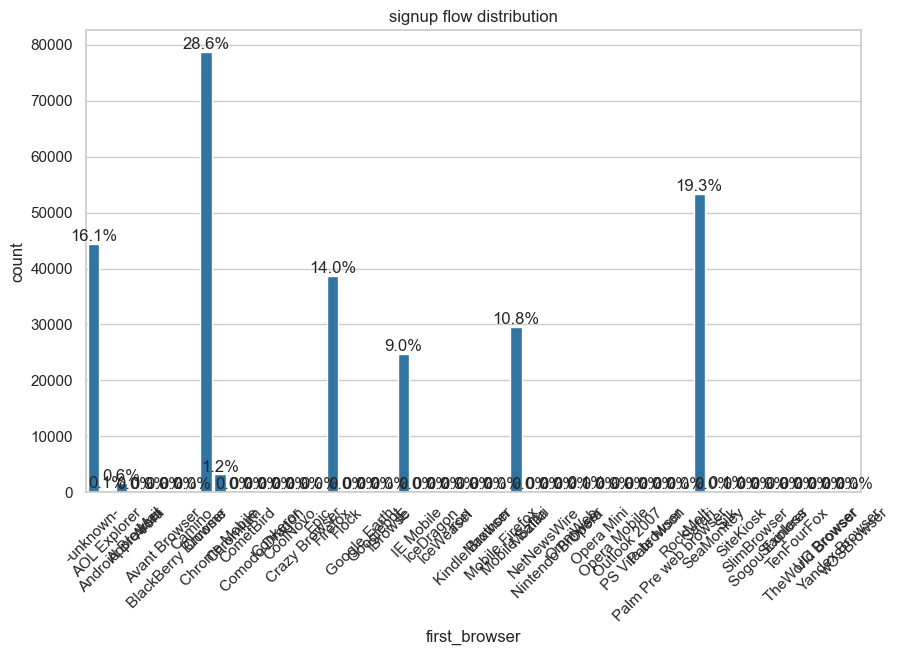

In [209]:
first_browser_counts = df_all['first_browser'].value_counts().sort_index()
total_count = len(df_all)


print(first_browser_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_all,x='first_browser', order=first_browser_counts.index)
plt.title('signup flow distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(first_browser_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

## 時間資料處理及視覺化

1. 年分 12 . 13 . 14 有較多資料，並有隨年份遞增的趨勢
2. 月份通常在7.8.9月有較多的資料，可以考慮把月份也變成一個有序類別變數

In [210]:
#轉格式
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

In [211]:
df_all['acc_year'] = df_all['date_account_created'].dt.year
df_year = df_all.groupby('acc_year').count()
#設定有序類別
years = [2010,2011,2012,2013,2014]
years_order = pd.api.types.CategoricalDtype(ordered=True,categories=years)
df_year.reset_index(inplace = True)
df_year.acc_year = df_year.acc_year.astype(years_order)

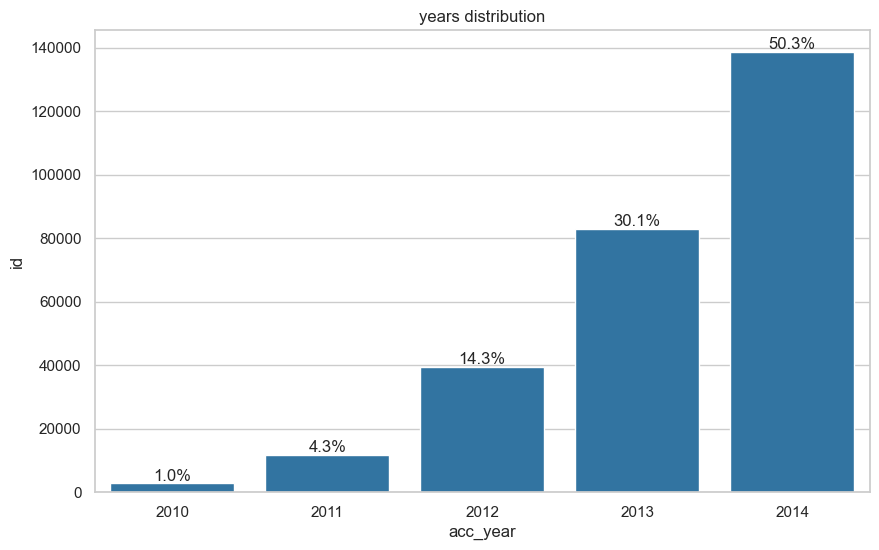

In [212]:
total_count = len(df_all)

plt.figure(figsize=(10,6))
sns.barplot(data=df_year,x='acc_year',y= 'id')
plt.title('years distribution')
# 旋轉X軸的字標籤
# plt.xticks(rotation=45)
# 添加標籤
for i in range(df_year.shape[0]):
    count = df_year.iloc[i]['id']
    percentage = f"{(count / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(i, count + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

C:\Users\oscar\AppData\Local\Temp\ipykernel_26548\200511466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_14['month_14'] = df_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_14
01-2014    11111
02-2014     9967
03-2014    12058
04-2014    12689
05-2014    14895
06-2014    15746
07-2014    21696
08-2014    21626
09-2014    18774
Name: count, dtype: int64


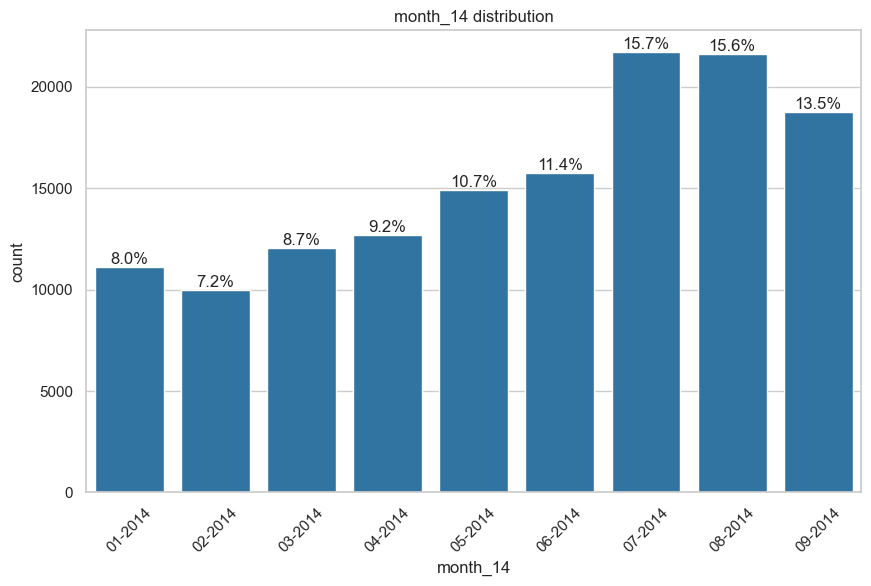

In [213]:
df_14 = df_all[df_all.date_account_created.dt.year==2014]
df_14['month_14'] = df_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_14_counts = df_14['month_14'].value_counts().sort_index()
total_count = len(df_14)


print(month_14_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_14,x='month_14', order=month_14_counts.index)
plt.title('month_14 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_14_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

C:\Users\oscar\AppData\Local\Temp\ipykernel_26548\878182506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_13['month_13'] = df_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_13
01-2013    4418
02-2013    4362
03-2013    5421
04-2013    5855
05-2013    6721
06-2013    6765
07-2013    7950
08-2013    8369
09-2013    9125
10-2013    7862
11-2013    7751
12-2013    8361
Name: count, dtype: int64


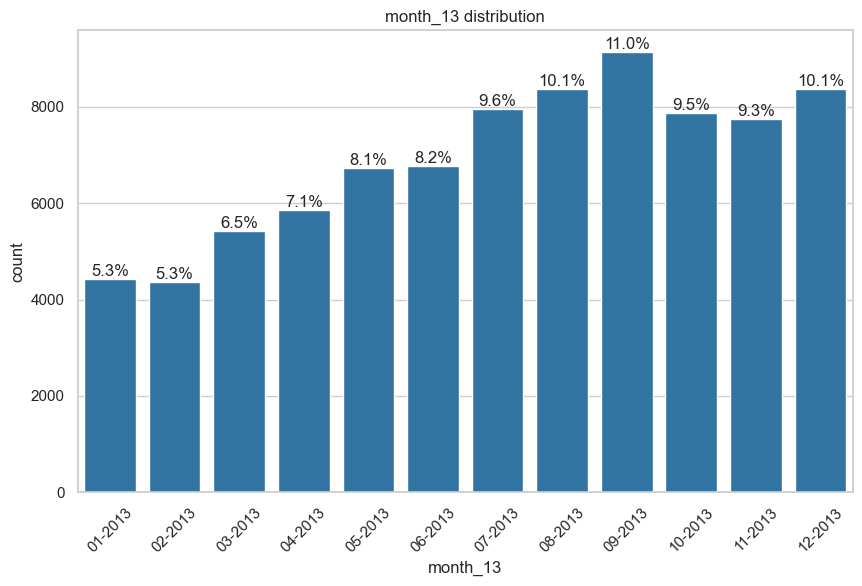

In [214]:
df_13 = df_all[df_all.date_account_created.dt.year==2013]
df_13['month_13'] = df_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_13_counts = df_13['month_13'].value_counts().sort_index()
total_count = len(df_13)


print(month_13_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_13,x='month_13', order=month_13_counts.index)
plt.title('month_13 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_13_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

C:\Users\oscar\AppData\Local\Temp\ipykernel_26548\795306023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['month_12'] = df_12['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_12
01-2012    1589
02-2012    1789
03-2012    2192
04-2012    2589
05-2012    3325
06-2012    3867
07-2012    4582
08-2012    4476
09-2012    4035
10-2012    3828
11-2012    3706
12-2012    3484
Name: count, dtype: int64


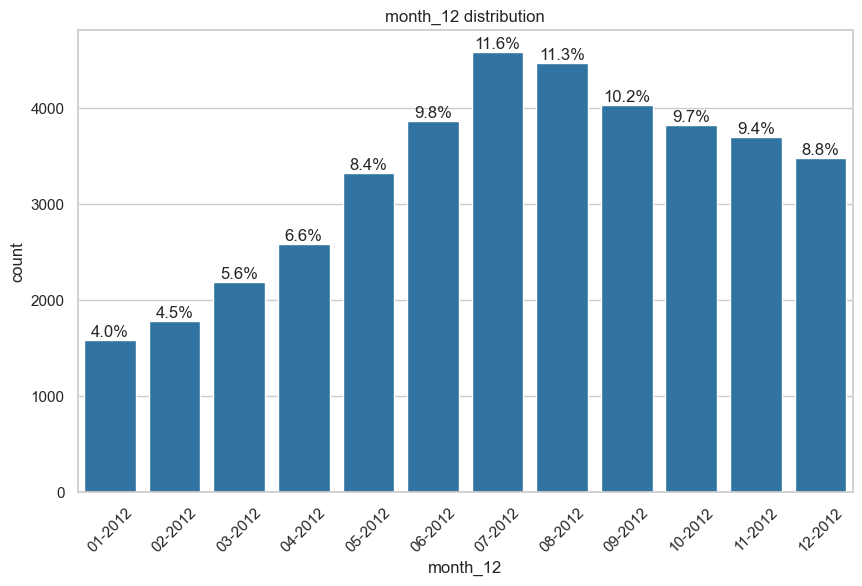

In [215]:
df_12 = df_all[df_all.date_account_created.dt.year==2012]
df_12['month_12'] = df_12['date_account_created'].map(lambda x: x.strftime('%m-%Y'))


month_12_counts = df_12['month_12'].value_counts().sort_index()
total_count = len(df_12)


print(month_12_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df_12,x='month_12', order=month_12_counts.index)
plt.title('month_12 distribution')
# 旋轉X軸的字標籤
plt.xticks(rotation=45)
# 添加標籤
for index, value in enumerate(month_12_counts):
    percentage = f"{(value / total_count) * 100:.1f}%"  # 計算百分比
    plt.text(index, value + 0.1, percentage, ha='center', va='bottom', fontsize=12)  

In [216]:
df_14

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,acc_year,month_14
422,oamfblpxdy,2014-01-15,2010-04-17 17:26:59,OTHER,45.0,basic,24,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,2014,01-2014
710,5p0nmf3r6i,2014-05-23,2010-05-28 14:06:42,FEMALE,39.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,2014,05-2014
1025,dlg3a9x97v,2014-04-03,2010-07-12 21:29:24,MALE,47.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,2014,04-2014
4180,p4oev43bwu,2014-02-11,2011-04-12 02:54:20,-unknown-,27.0,basic,0,en,sem-brand,google,untracked,Web,iPhone,-unknown-,2014,02-2014
4434,r6mv11jano,2014-01-29,2011-04-24 11:19:01,-unknown-,26.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,2014,01-2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,cv0na2lf5a,2014-09-30,2014-09-30 23:52:32,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,2014,09-2014
275543,zp8xfonng8,2014-09-30,2014-09-30 23:53:06,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-,2014,09-2014
275544,fa6260ziny,2014-09-30,2014-09-30 23:54:08,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox,2014,09-2014
275545,87k0fy4ugm,2014-09-30,2014-09-30 23:54:30,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,2014,09-2014


# Correlation Analysis

In [221]:
df_all.acc_year = df_all.acc_year.astype(years_order)
print(df_all.dtypes)


id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                           category
age                               float64
signup_method                    category
signup_flow                      category
language                         category
affiliate_channel                category
affiliate_provider               category
first_affiliate_tracked          category
signup_app                       category
first_device_type                category
first_browser                    category
acc_year                         category
dtype: object


In [220]:
feature = [
    'gender',
    'age',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'acc_year'
]

order_category = ['acc_year']
non_order_category = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser' 
]

#lable encoding
label_encoder = LabelEncoder()
df_all[order_category] = label_encoder.fit_transform(df_all[order_category])

#onehot encoding



# 假設df_all是你的資料框
# 計算相關矩陣
correlation_matrix = df_all.corr()

# 使用熱圖視覺化相關矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


ValueError: could not convert string to float: 'gxn3p5htnn'